In [1]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import pandas as pd
cutoff_value = 0.99

In [2]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(0)

print("Running...")


thr_std=0.2

E = Events("CheatedRecoFile_1.root")

view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")

u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x

v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x

Running...


In [3]:
def importpdf(filename):
    df = pd.read_csv(filename)
    df = df.fillna(0)
    data = df.values
    return data[0][1:], data[1][1:]

In [4]:
def normalisepdfs(signal_data_path, background_data_path):
    background_hist_values, background_bin_values = importpdf(background_data_path)
    background_hist_values = np.nan_to_num(background_hist_values)
    background_hist_values = background_hist_values.astype(np.float64)
    background_bin_values = background_bin_values.astype(np.float64)
    background_bin_values = np.nan_to_num(background_bin_values)
    
    signal_hist_values, signal_bin_values = importpdf(signal_data_path)
    signal_hist_values = np.nan_to_num(signal_hist_values)
    signal_hist_values = signal_hist_values.astype(np.float64)
    signal_bin_values = signal_bin_values.astype(np.float64)
    signal_bin_values = np.nan_to_num(signal_bin_values)
    
    #print(background_hist_values, signal_hist_values)
    total_hist_values = background_hist_values + signal_hist_values
    #print("\n", total_hist_values)
    
    normalised_background = background_hist_values[:-1] / total_hist_values[:-1]
    normalised_signal = signal_hist_values[:-1] / total_hist_values[:-1]
    
    return normalised_signal, signal_bin_values[:-1], normalised_background, background_bin_values[:-1]

In [5]:
def plotpdf(normalised_signal, signal_bin_values, normalised_background, background_bin_values):
    plt.title("Signal (red) - Background (blue) PDFs")
    plt.xlabel("Normalised Metric Score")
    plt.ylabel("PDF Probability")
    plt.plot(signal_bin_values, normalised_signal, '.r-')
    plt.plot(background_bin_values, normalised_background, '.b-')
    plt.show()
    return 0

In [6]:
import bisect
def interpolate_pdf(normalised_signal, signal_bin_values, scores):
    prob = [None] * len(scores)
    for i in range(len(scores)):
        idx = bisect.bisect(signal_bin_values, scores[i])
        if 0 < idx < len(signal_bin_values):
            prob[i] = normalised_signal[idx-1]
    prob = [0.99 if v is None else v for v in prob]
    return prob
        

In [10]:
normalised_signal, signal_bin_values, normalised_background, background_bin_values = normalisepdfs("signal_lz_hist.csv", "back_lz_hist.csv")
print(normalised_signal)
print(normalised_background)
print("\n", signal_bin_values)
#plotpdf(normalised_signal, signal_bin_values, normalised_background, background_bin_values)

[0.08661901 0.25762013 0.31390201 0.20817197 0.22292998 0.28318114
 0.31528795 0.31265205 0.3535971  0.40343701 0.42965071 0.42499954
 0.45539155 0.51765608 0.48948927 0.58292431 0.63837028 0.7026183
 0.80817008 0.921195  ]
[0.91338099 0.74237987 0.68609799 0.79182803 0.77707002 0.71681886
 0.68471205 0.68734795 0.6464029  0.59656299 0.57034929 0.57500046
 0.54460845 0.48234392 0.51051073 0.41707569 0.36162972 0.2973817
 0.19182992 0.078805  ]

 [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]


In [8]:
prob = interpolate_pdf(normalised_signal, signal_bin_values, [0, 0.41, 1])
print(prob)

[0.5381116494638807, 0.3915933865182917, 0.99]


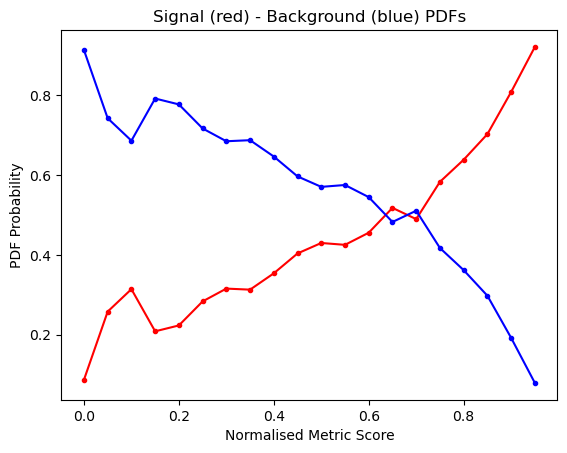

0

In [9]:
normalised_signal, signal_bin_values, normalised_background, background_bin_values = normalisepdfs("signal_lz_hist.csv", "back_lz_hist.csv")
plotpdf(normalised_signal, signal_bin_values, normalised_background, background_bin_values)

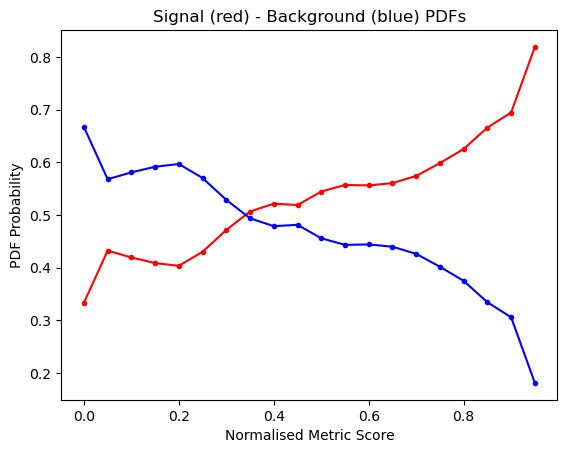

0

In [50]:
normalised_signal, signal_bin_values, normalised_background, background_bin_values = normalisepdfs("signal_rphi_hist.csv", "back_rphi_hist.csv")
plotpdf(normalised_signal, signal_bin_values, normalised_background, background_bin_values)

In [51]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def AoI(plane, event_number, thresholding=True, no_std=thr_std):
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
    
    return AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx

def plotter(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)


    
    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0


# Least Z Probability Calculation

In [52]:
def least_z_scores(plane, event):
    x_view, z_view, adc_view, true_z, true_x = AoI(plane, event)
    z_scores = [None] * len(x_view)
    min_z = np.amin(z_view)
    ind = np.where(min_z)[0]
    min_x = x_view[ind]
    for i in range(len(x_view)):
        z_scores[i] = z_view[ind] - z_view[i]
    
    score_max = max(z_scores)
    score_min = min(z_scores)
    
    normalised_scores = (z_scores - score_min) / (score_max - score_min)
    
    return normalised_scores

In [92]:
def calculate_probability_lz(plane, event):
    scores = least_z_scores(plane, event)
    norm_signal, signal_bin, norm_background, background_bin = normalisepdfs("signal_lz_hist.csv", "back_lz_hist.csv")
    prob = interpolate_pdf(norm_signal, signal_bin, scores)

    return prob


# RPHI Probability Calculation

In [56]:
def rfunc(r):
    return 1/((r+0.01)**(1/2))

def rphi(plane, event_number, thresholding=True, no_std=thr_std, centre_coord=(0,0), func=rfunc, no_sectors=5, centre=0):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]
    
    cen_r = (centred_x**2 + centred_z**2)**0.5
    #distance from central point to every other point
    

    #make the problem tractable (solvable)
    
    weight = rfunc(cen_r)

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre), weights=weight)
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    
    return norm_score

def optimise_phi(plane, event_number, thresholding=True, no_std=thr_std, no_sectors=20, centre=0, plot=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    no_points = len(AoI_x)
    score_arr = np.zeros(no_points)
    for i in range(no_points):
        centre_co = (AoI_z[i], AoI_x[i])
        score_arr[i] = rphi(plane, event_number, centre_coord=centre_co)
    
    ind = np.argmax(score_arr)
    zmin, xmin = AoI_z[ind], AoI_x[ind]
    if plot:
        plotter(plane, event_number, thresholding, no_std)
        plt.plot(zmin, xmin, 'ro')
        plt.show()
    return zmin, xmin, score_arr[ind], score_arr

def rphi_scores(plane, event_number, function=optimise_phi, dependence=np.exp, plot=False, thresholding=True, no_std=thr_std, no_sectors=5):
    AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, event_number, thresholding, no_std)
    Zvert_place, Xvert_place = function(plane, event_number, no_sectors)[0], function(plane, event_number, no_sectors)[1]
    score_max, score_array = function(plane, event_number, no_sectors)[2], function(plane, event_number, no_sectors)[3]
    
    score_min = np.min(score_array)
    
    normalised_scores = (score_array - score_min) / (score_max - score_min)
    
    if plot:
        plt.plot(AoI_z, AoI_x, 'o')
        plt.show()
        plt.plot(AoI_z, normalised_scores, 'ro')
        plt.show()
    return normalised_scores


In [91]:
def calculate_probability_rphi(plane, event):
    scores = rphi_scores(plane, event)
    norm_signal, signal_bin, norm_background, background_bin = normalisepdfs("signal_rphi_hist.csv", "back_rphi_hist.csv")
    prob = interpolate_pdf(norm_signal, signal_bin, scores)

    return prob

# QuadVertex Probability Calculation

In [58]:
def line_finder(point1, point2):
    slope = (point1[1] - point2[1])/(point1[0] - point2[0])
    intercept = point1[1] - slope * point1[0]
    return slope, intercept

def line_intersect(slope1, intercept1, slope2, intercept2):
    x_point = (intercept2 - intercept1)/(slope1 - slope2)
    z_point = slope1 * x_point + intercept1
    return x_point, z_point

def check_valid_intersection(point1, point2, point3, point4, range_x, range_z):
    slope1, intercept1 = line_finder(point1, point2)
    slope2, intercept2 = line_finder(point3, point4)
    x_point, z_point = line_intersect(slope1, intercept1, slope2, intercept2)
    x_vertices = [point1[0], point2[0], point3[0], point4[0]]
    z_vertices = [point1[1], point2[1], point3[1], point4[1]]
    x_max, x_min = max(x_vertices), min(x_vertices)
    z_max, z_min = max(z_vertices), min(z_vertices)
    angle1, angle2 = np.arctan(slope1), np.arctan(slope2)
    if x_point > x_min and x_point < x_max:
        if z_point > z_min and z_point < z_max:
            if angle1 < 0.8*angle2 or angle1 > 1.25*angle2: 
                return x_point, z_point
            else:
                return "fail 1", angle1, angle2
        else:
            return "fail 2"
    else:
        return "fail 3"

def get_valid_points(point1, point2, point3, point4, range_x, range_z):
    initial_vertices = [0, 0]
    try:
        initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point2, point3, point4, range_x, range_z)
        #print("V1")
        return initial_vertices
    except:
        try:
            initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point3, point2, point4, range_x, range_z)
            #print("V2")
            return initial_vertices
        except:
            try:
                initial_vertices[0], initial_vertices[1] = check_valid_intersection(point1, point4, point2, point3, range_x, range_z)
                #print("V3")
                return initial_vertices
            except:
                #print("Fail", point1, point2, point3, point4) 
                return False

def select_random_points(AoI_x, AoI_z, AoI_adc, iterations="scaled", no_std=thr_std):
    if iterations == "scaled":
        iterations = int((len(AoI_x))*4)
        initial_vertex_points = np.zeros((iterations, 2))
        vertex_length = len(AoI_x)
        if vertex_length > 4:
            range_x = (np.amin(AoI_x), np.amax(AoI_x))
            range_z = (np.amin(AoI_z), np.amax(AoI_z))
            for i in range(iterations):
                sample = random.sample(range(0, vertex_length), 4)
                vtxind_1, vtxind_2, vtxind_3, vtxind_4 = sample[0], sample[1], sample[2], sample[3]
                point1, point2, point3, point4 = (AoI_x[vtxind_1], AoI_z[vtxind_1]), (AoI_x[vtxind_2], AoI_z[vtxind_2]), (AoI_x[vtxind_3], AoI_z[vtxind_3]), (AoI_x[vtxind_4], AoI_z[vtxind_4])
                try:
                    initial_vertex_points[i, 0], initial_vertex_points[i, 1] = get_valid_points(point1, point2, point3, point4, range_x, range_z)
                except:
                    pass
                '''
                print("Sample: ", sample)
                print("Slope 1: ", slope1)
                print("Slope 2: ", slope2)
                print("Intercept 1: ", intercept1)
                print("Intercept 2: ", intercept2)
                print("$$$$$$$$    X-point, Z-point    $$$$$$$$: ", x_point, y_point)
                '''
    else:
        initial_vertex_points = np.zeros((iterations, 2))
        vertex_length = len(AoI_x)
        if vertex_length > 4:
            range_x = (np.amin(AoI_x), np.amax(AoI_x))
            range_z = (np.amin(AoI_z), np.amax(AoI_z))
            for i in range(iterations):
                sample = random.sample(range(0, vertex_length), 4)
                vtxind_1, vtxind_2, vtxind_3, vtxind_4 = sample[0], sample[1], sample[2], sample[3]
                point1, point2, point3, point4 = (AoI_x[vtxind_1], AoI_z[vtxind_1]), (AoI_x[vtxind_2], AoI_z[vtxind_2]), (AoI_x[vtxind_3], AoI_z[vtxind_3]), (AoI_x[vtxind_4], AoI_z[vtxind_4])
                try:
                    initial_vertex_points[i, 0], initial_vertex_points[i, 1] = get_valid_points(point1, point2, point3, point4, range_x, range_z)
                except:
                    pass
    return initial_vertex_points

def heatmap4points(plane, event_number, thresholding=False, no_std=thr_std, iterations=10000, bins=100):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    vertex_points = select_random_points(AoI_x, AoI_z, AoI_adc, iterations)
    vertex_points = vertex_points[~np.all(vertex_points == 0, axis=1)] #removes all the 0,0 vertices
    
    
    histvertex = plt.hist2d(vertex_points[:,1], vertex_points[:,0], bins=(bins, bins), cmap=plt.cm.jet)
    plt.title(str(plane) + str(event_number))
    plt.close()
    histogram_array = histvertex[0]
    max_value = np.amax(histogram_array)
    indices = np.where(histogram_array == max_value)
    z_value = histvertex[1][indices[0]]
    x_value = histvertex[2][indices[1]]

    return z_value[0], x_value[0], histogram_array, histvertex[1], histvertex[2]

def quadvertex_scores(plane, event_number, binwidth=(100,100), binradius=3):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number)
    
    h, zedges, xedges = heatmap4points(plane, event_number)[2], heatmap4points(plane, event_number)[3], heatmap4points(plane, event_number)[4]

    zbins = np.digitize(AoI_z, zedges) - 2 
    xbins = np.digitize(AoI_x, xedges) - 2
    
    zxbins = np.concatenate((zbins[...,None],xbins[...,None]), axis=1) 
    
    weights = h[zxbins[:,0], zxbins[:,1]]
    
    scores = weights/np.amax(weights)
    return scores

In [90]:
def calculate_probability_quad(plane, event):
    scores = quadvertex_scores(plane, event)
    norm_signal, signal_bin, norm_background, background_bin = normalisepdfs("signal_quad_hist.csv", "back_quad_hist.csv")
    prob = interpolate_pdf(norm_signal, signal_bin, scores)
    
    return prob

# Full Likelihood Calculation

In [106]:
def calculate_likelihood(plane, event):
    
    prob_lz = np.array(calculate_probability_lz(plane, event))
    #prob_lz = np.transpose(prob_lz)
    prob_rphi = np.array(calculate_probability_rphi(plane, event))
    prob_quad = np.array(calculate_probability_quad(plane, event))
    
    #print(len(prob_lz), len(prob_rphi), len(prob_quad))
    #print(prob_lz, prob_rphi, prob_quad)
    
    signal_likelihood = prob_lz * prob_rphi * prob_quad
    back_likelihood = (1 - prob_lz) * (1 - prob_rphi) * (1 - prob_quad)
    
    likelihood = signal_likelihood / (signal_likelihood + back_likelihood)
    
    return likelihood, prob_lz, prob_rphi, prob_quad

In [100]:
sample = random.sample(range(0, len(u_x)), 3000)
likelihoods = calculate_likelihood("u", 40)

599 599 599


In [101]:
print(likelihoods)

(array([0.85798692, 0.85798692, 0.72066025, 0.99775235, 0.89933174,
       0.91061569, 0.89933174, 0.88207307, 0.88207307, 0.88207307,
       0.88207307, 0.88207307, 0.88207307, 0.88207307, 0.8698085 ,
       0.88207307, 0.8698085 , 0.8698085 , 0.8698085 , 0.8698085 ,
       0.8698085 , 0.8698085 , 0.8698085 , 0.8698085 , 0.8698085 ,
       0.8698085 , 0.8698085 , 0.8698085 , 0.85798692, 0.85798692,
       0.85798692, 0.85798692, 0.85798692, 0.85798692, 0.85798692,
       0.85798692, 0.85798692, 0.85798692, 0.85798692, 0.85798692,
       0.85107072, 0.85107072, 0.85107072, 0.85107072, 0.85107072,
       0.85107072, 0.85107072, 0.85107072, 0.85107072, 0.85107072,
       0.85107072, 0.85107072, 0.85107072, 0.76217799, 0.76217799,
       0.76217799, 0.76217799, 0.76217799, 0.76217799, 0.76217799,
       0.76217799, 0.76217799, 0.76217799, 0.76217799, 0.76217799,
       0.75904607, 0.75904607, 0.75904607, 0.75029819, 0.84887733,
       0.84887733, 0.75029819, 0.75029819, 0.72066025, 0.9908

In [74]:
print(np.amax(likelihoods), np.argmax(likelihoods))

0.9972226075339466 0


In [123]:
def find_accuracy_likelihoods(plane, event):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event)
    
    likelihoods, prob_lz, prob_rphi, prob_quad = calculate_likelihood(plane, event)
        
    ind = np.argmax(likelihoods)
    z_diff = np.abs(AoI_truevtxz - AoI_z[ind])
    x_diff = np.abs(AoI_truevtxx - AoI_x[ind])
    r_diff = (x_diff ** 2 + z_diff ** 2)**(1/2)
    
    return z_diff, x_diff, r_diff

def create_likelihoods_metrics(plane, sample):
    
    x_hist_data = [None] * len(sample)
    z_hist_data = [None] * len(sample)
    r_hist_data = [None] * len(sample)
    for i in tqdm(range(len(sample))):
        z_hist_data[i], x_hist_data[i], r_hist_data[i] = find_accuracy_likelihoods(plane, sample[i])
    
    return z_hist_data, x_hist_data, r_hist_data

sample = random.sample(range(0, len(u_x)), 3000)

In [105]:
print(find_accuracy_likelihoods("u", 14))

517 517 517
(37.271606, 13.240013, 39.55338916578179)


In [107]:
z_hist_data, x_hist_data, r_hist_data = create_likelihoods_metrics([2000, 1000, 3000])

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)


In [110]:
print(z_hist_data, x_hist_data, r_hist_data)
z_hist_data, x_hist_data, r_hist_data = create_likelihoods_metrics(sample)

[17.701271, 409.639, 1.5546265] [11.902458, 209.70374, 2.460785] [21.330811236905635, 460.1953641031041, 2.910725996870492]


  0%|                                                                               | 2/3000 [00:02<1:13:37,  1.47s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
  0%|                                                                               | 3/3000 [00:04<1:14:25,  1.49s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  0%|▏                                      

  2%|█▎                                                                            | 49/3000 [01:13<1:01:53,  1.26s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  2%|█▎                                                                            | 51/3000 [01:16<1:05:46,  1.34s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  2%|█▍                                                     

  3%|██▌                                                                           | 99/3000 [02:19<1:06:42,  1.38s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
  3%|██▋                                                                            | 101/3000 [02:21<58:09,  1.20s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

  6%|████▌                                                                          | 172/3000 [03:41<48:48,  1.04s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  6%|████▌                                                                          | 175/3000 [03:44<51:19,  1.09s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_

  7%|█████▌                                                                       | 216/3000 [04:43<1:11:39,  1.54s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  7%|█████▌                                                                       | 217/3000 [04:45<1:08:40,  1.48s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  7%|█████▌                                                 

  8%|██████▍                                                                      | 249/3000 [05:25<1:12:58,  1.59s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  8%|██████▍                                                                      | 250/3000 [05:26<1:02:55,  1.37s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  8%|██████▌                                                

 10%|███████▍                                                                     | 289/3000 [06:17<1:11:00,  1.57s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 10%|███████▍                                                                     | 290/3000 [06:18<1:02:45,  1.39s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736

 11%|████████▋                                                                      | 332/3000 [07:13<55:08,  1.24s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 11%|████████▊                                                                      | 333/3000 [07:14<51:31,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 11%|████████▋                                              

 14%|██████████▉                                                                  | 427/3000 [09:21<1:01:23,  1.43s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 14%|███████████▎                                                                   | 428/3000 [09:22<53:15,  1.24s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 14%|███████████                                            

 15%|████████████                                                                   | 457/3000 [09:56<41:43,  1.02it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 15%|████████████                                                                   | 458/3000 [09:57<40:07,  1.06it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 15%|████████████▏                                          

 17%|█████████████▎                                                                 | 504/3000 [10:54<59:27,  1.43s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 17%|█████████████▎                                                                 | 505/3000 [10:55<53:38,  1.29s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 17%|█████████████                                          

 18%|██████████████▍                                                                | 546/3000 [11:48<54:37,  1.34s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 18%|██████████████▍                                                                | 547/3000 [11:49<51:37,  1.26s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 18%|██████████████▌                                        

 20%|███████████████▍                                                               | 585/3000 [12:34<50:22,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 20%|███████████████▌                                                               | 593/3000 [12:45<54:37,  1.36s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 20%|████████████████                                       

 21%|████████████████▎                                                            | 636/3000 [13:43<1:25:22,  2.17s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 21%|████████████████▉                                                              | 641/3000 [13:48<46:00,  1.17s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 21%|████████████████▉                      

 23%|██████████████████▍                                                            | 701/3000 [15:20<41:45,  1.09s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 24%|██████████████████                                                           | 706/3000 [15:28<1:00:21,  1.58s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 24%|██████████████████▋                                    

 26%|████████████████████▌                                                          | 779/3000 [17:09<47:25,  1.28s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 26%|████████████████████▌                                                          | 780/3000 [17:10<44:32,  1.20s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 26%|████████████████████▌                                  

 27%|█████████████████████▎                                                         | 807/3000 [17:42<42:43,  1.17s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 27%|█████████████████████▎                                                         | 809/3000 [17:45<45:49,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 27%|█████████████████████▎                 

 30%|███████████████████████▎                                                       | 885/3000 [19:20<36:56,  1.05s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 30%|███████████████████████▍                                                       | 889/3000 [19:26<51:47,  1.47s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 30%|███████████████████████▍                               

 31%|████████████████████████▌                                                      | 934/3000 [20:21<47:57,  1.39s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 31%|████████████████████████▌                                                      | 935/3000 [20:22<44:44,  1.30s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 31%|████████████████████████▋                              

 33%|█████████████████████████▋                                                     | 976/3000 [21:18<45:43,  1.36s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 33%|█████████████████████████▋                                                     | 977/3000 [21:19<38:53,  1.15s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 33%|█████████████████████████▊                                                     | 978/3000 [21:20<37:11,  1.10s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x

 34%|██████████████████████████▎                                                   | 1012/3000 [22:01<39:27,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 34%|██████████████████████████▎                                                   | 1014/3000 [22:03<35:29,  1.07s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 34%|██████████████████████████▍                            

 35%|███████████████████████████▍                                                  | 1054/3000 [22:55<38:05,  1.17s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 35%|███████████████████████████▍                                                  | 1055/3000 [22:56<34:24,  1.06s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 35%|███████████████████████████▌                           

 38%|█████████████████████████████▋                                                | 1144/3000 [24:54<35:18,  1.14s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 38%|█████████████████████████████▊                                                | 1146/3000 [24:57<41:16,  1.34s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 38%|█████████████████████████████▊                         

 41%|████████████████████████████████▏                                             | 1236/3000 [26:58<38:20,  1.30s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 41%|████████████████████████████████▏                                             | 1239/3000 [27:01<32:38,  1.11s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 41%|████████████████████████████████▏                      

 44%|██████████████████████████████████                                            | 1309/3000 [28:35<36:40,  1.30s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 44%|██████████████████████████████████▏                                           | 1313/3000 [28:40<37:21,  1.33s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 44%|██████████████████████████████████▏                    

 45%|███████████████████████████████████▏                                          | 1355/3000 [29:27<31:25,  1.15s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 45%|███████████████████████████████████▎                                          | 1356/3000 [29:28<29:24,  1.07s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 45%|███████████████████████████████████▎   

 46%|████████████████████████████████████                                          | 1389/3000 [30:14<50:03,  1.86s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 46%|████████████████████████████████████▏                                         | 1390/3000 [30:15<42:43,  1.59s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 46%|████████████████████████████████████▏                  

 49%|██████████████████████████████████████                                        | 1465/3000 [31:50<36:21,  1.42s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 49%|██████████████████████████████████████▏                                       | 1468/3000 [31:56<43:10,  1.69s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 49%|██████████████████████████████████████▏                

 50%|███████████████████████████████████████                                       | 1500/3000 [32:40<36:11,  1.45s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 50%|███████████████████████████████████████                                       | 1501/3000 [32:40<31:52,  1.28s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

 52%|████████████████████████████████████████▉                                     | 1573/3000 [34:04<28:22,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 53%|████████████████████████████████████████▉                                     | 1576/3000 [34:08<32:27,  1.37s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 53%|█████████████████████████████████████████              

 54%|██████████████████████████████████████████                                    | 1620/3000 [35:07<28:13,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 54%|██████████████████████████████████████████▏                                   | 1621/3000 [35:08<27:27,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 54%|██████████████████████████████████████████▏                                   | 1623/3000 [35:10<24:11,  1.05s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by 

 55%|███████████████████████████████████████████▏                                  | 1662/3000 [35:58<26:17,  1.18s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 55%|███████████████████████████████████████████▏                                  | 1663/3000 [35:59<27:11,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 56%|███████████████████████████████████████████▎           

 57%|████████████████████████████████████████████▍                                 | 1710/3000 [37:01<35:05,  1.63s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 57%|████████████████████████████████████████████▌                                 | 1712/3000 [37:05<36:31,  1.70s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 57%|████████████████████████████████████████████▌          

 58%|█████████████████████████████████████████████▎                                | 1742/3000 [37:45<21:47,  1.04s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 58%|█████████████████████████████████████████████▎                                | 1743/3000 [37:46<22:15,  1.06s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 58%|█████████████████████████████████████████████▎         

 59%|██████████████████████████████████████████████▎                               | 1781/3000 [38:42<26:14,  1.29s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 59%|██████████████████████████████████████████████▎                               | 1782/3000 [38:44<26:42,  1.32s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 60%|██████████████████████████████████████████████▍        

 62%|████████████████████████████████████████████████▍                             | 1863/3000 [40:37<21:17,  1.12s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 62%|████████████████████████████████████████████████▍                             | 1864/3000 [40:38<22:32,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 62%|████████████████████████████████████████████████▌      

 63%|█████████████████████████████████████████████████▎                            | 1897/3000 [41:27<24:07,  1.31s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 63%|█████████████████████████████████████████████████▎                            | 1899/3000 [41:29<20:57,  1.14s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 63%|█████████████████████████████████████████████████▍     

 65%|██████████████████████████████████████████████████▎                           | 1936/3000 [42:16<21:16,  1.20s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 65%|██████████████████████████████████████████████████▍                           | 1941/3000 [42:23<22:52,  1.30s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 65%|███████████████████████████████████████

 66%|███████████████████████████████████████████████████▋                          | 1990/3000 [43:36<25:09,  1.49s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 66%|███████████████████████████████████████████████████▊                          | 1991/3000 [43:38<23:45,  1.41s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 66%|███████████████████████████████████████████████████▊   

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 67%|████████████████████████████████████████████████████▌                         | 2022/3000 [44:23<25:38,  1.57s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 68%|████████████████████████████████████████████████████▋                         | 2025/3000 [44:26<20:07,  1.24s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 69%|█████████████████████████████████████████████████████▉                        | 2076/3000 [45:39<20:36,  1.34s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 70%|██████████████████████████████████████████████████████▏                       | 2086/3000 [45:54<23:50,  1.57s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 71%|███████████████████████████████████████████████████████▎                      | 2127/3000 [46:50<17:15,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 71%|███████████████████████████████████████████████████████▌                      | 2135/3000 [47:06<37:20,  2.59s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: 

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 74%|█████████████████████████████████████████████████████████▌                    | 2214/3000 [49:08<16:21,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 74%|█████████████████████████████████████████████████████████▌                    | 2216/3000 [49:10<14:59,  1.15s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

 77%|████████████████████████████████████████████████████████████                  | 2309/3000 [51:27<16:59,  1.48s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 77%|████████████████████████████████████████████████████████████                  | 2310/3000 [51:29<16:30,  1.44s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 77%|███████████████████████████████████████

 79%|█████████████████████████████████████████████████████████████▉                | 2383/3000 [53:20<13:28,  1.31s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 79%|█████████████████████████████████████████████████████████████▉                | 2384/3000 [53:22<14:32,  1.42s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 80%|██████████████████████████████████████████████████████████████                | 2385/3000 [53:23<13:13,  1.29s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  s

 82%|███████████████████████████████████████████████████████████████▉              | 2461/3000 [55:18<21:06,  2.35s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 82%|████████████████████████████████████████████████████████████████              | 2462/3000 [55:19<17:18,  1.93s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 82%|███████████████████████████████████████████████████████

 84%|█████████████████████████████████████████████████████████████████▍            | 2516/3000 [56:49<10:51,  1.35s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 84%|█████████████████████████████████████████████████████████████████▍            | 2519/3000 [56:53<11:08,  1.39s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_

 86%|███████████████████████████████████████████████████████████████████▎          | 2588/3000 [58:59<14:00,  2.04s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 86%|███████████████████████████████████████████████████████████████████▍          | 2592/3000 [59:03<08:04,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 86%|███████████████████████████████████████████████████████

 88%|████████████████████████████████████████████████████████████████████▎         | 2627/3000 [59:49<07:40,  1.24s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 88%|████████████████████████████████████████████████████████████████████▎         | 2628/3000 [59:50<07:09,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736

 89%|███████████████████████████████████████████████████████████████████▍        | 2664/3000 [1:00:35<07:19,  1.31s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 89%|███████████████████████████████████████████████████████████████████▌        | 2665/3000 [1:00:36<06:39,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 89%|███████████████████████████████████████

 90%|████████████████████████████████████████████████████████████████████▍       | 2701/3000 [1:01:24<07:29,  1.50s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 90%|████████████████████████████████████████████████████████████████████▍       | 2703/3000 [1:01:29<09:16,  1.87s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 90%|███████████████████████████████████████

 91%|█████████████████████████████████████████████████████████████████████▏      | 2729/3000 [1:01:58<05:39,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 91%|█████████████████████████████████████████████████████████████████████▏      | 2730/3000 [1:01:59<05:14,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736

 94%|███████████████████████████████████████████████████████████████████████▏    | 2809/3000 [1:03:49<03:55,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 94%|███████████████████████████████████████████████████████████████████████▎    | 2815/3000 [1:03:58<04:27,  1.44s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 94%|███████████████████████████████████████

 97%|█████████████████████████████████████████████████████████████████████████▍  | 2900/3000 [1:06:06<02:39,  1.60s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 97%|█████████████████████████████████████████████████████████████████████████▌  | 2905/3000 [1:06:12<01:56,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 97%|███████████████████████████████████████████████████████

 98%|██████████████████████████████████████████████████████████████████████████▏ | 2929/3000 [1:06:41<01:26,  1.21s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 98%|██████████████████████████████████████████████████████████████████████████▎ | 2932/3000 [1:06:46<01:45,  1.55s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 98%|███████████████████████████████████████

 99%|███████████████████████████████████████████████████████████████████████████▌| 2981/3000 [1:07:52<00:29,  1.56s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 99%|███████████████████████████████████████████████████████████████████████████▌| 2984/3000 [1:07:56<00:22,  1.42s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
100%|███████████████████████████████████████

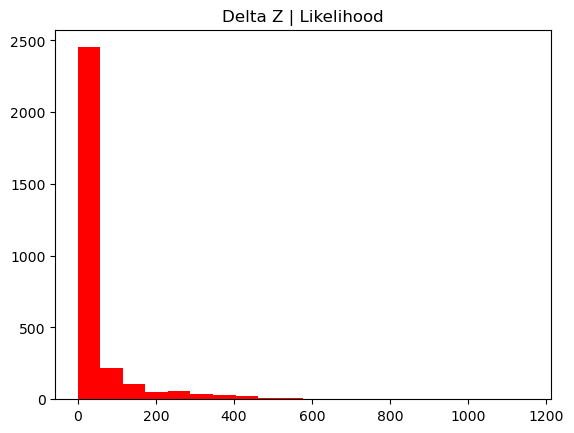

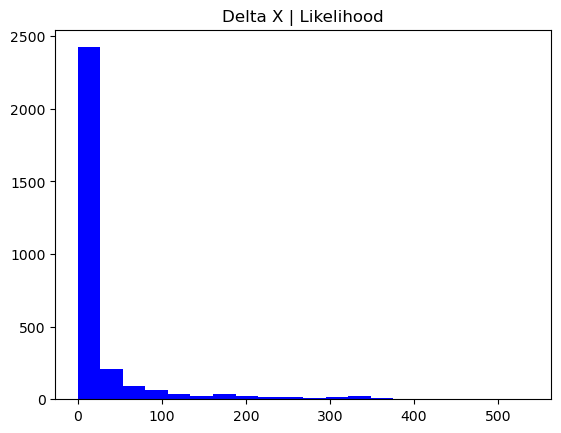

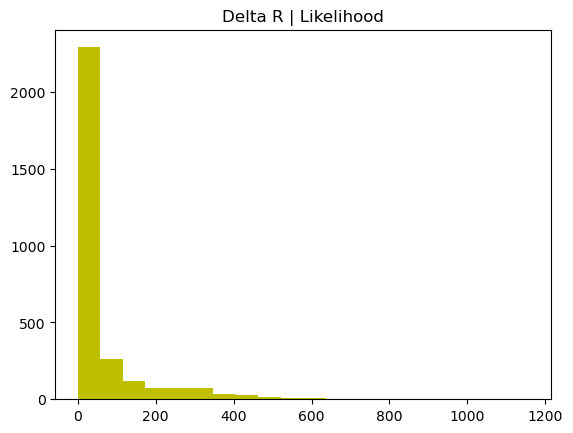

In [111]:
plt.clf()
x = plt.hist(z_hist_data, 20, color='r')
title = plt.title("Delta Z | Likelihood")
plt.show()

plt.clf()
x = plt.hist(x_hist_data, 20, color='b')
title = plt.title("Delta X | Likelihood")
plt.show()

plt.clf()
x = plt.hist(r_hist_data, 20, color='y')
title = plt.title("Delta R | Likelihood")
plt.show()

In [112]:
def create_r68_and_50cm(hist_data):
    r68 =  np.percentile(hist_data, 68)
    fifty_cm_list = [num for num in hist_data if num > 50]
    pecentage_fifty_cm = len(fifty_cm_list) / len(hist_data)
    
    return r68, pecentage_fifty_cm

In [113]:
r68Z, pecentage_fifty_cmZ = create_r68_and_50cm(z_hist_data)
r68X, pecentage_fifty_cmX = create_r68_and_50cm(x_hist_data)
r68R, pecentage_fifty_cmR = create_r68_and_50cm(r_hist_data)

print(r68Z, pecentage_fifty_cmZ)
print(r68X, pecentage_fifty_cmX)
print(r68R, pecentage_fifty_cmR)

25.23687133789063 0.20266666666666666
11.216390075683599 0.128
33.969050926432494 0.256


In [114]:
interaction_dictionary = {}

import pandas as pd
import csv
import pandas as pd
import numpy as np

with open('interactions.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        key = int(row.pop('Idx'))
        interaction = row.pop('Interaction')
        interaction_dictionary[key] = interaction
        
def interaction_finder(events):
    all_events = np.unique(events.event_number)
    x = [ events.interaction_type[np.where(events.event_number == e)] for e in all_events ]
    return x

def interaction_selector(interaction_dictionary):
    #CC and NC Split
    CC_indexes = []
    NC_indexes = []
    QEL_indexes = []
    DIS_indexes = []
    RES_indexes = []
    EL_indexes = []
    MU_indexes = []
    
    for i in range(len(interaction_dictionary)):
        first_two = (interaction_dictionary[i])[:2]
        if first_two == 'CC':
            CC_indexes.append(i)
        elif first_two == 'NC':
            NC_indexes.append(i)
            
    for i in range(len(interaction_dictionary)):
        first_three = (interaction_dictionary[i])[2:5]
        if first_three == 'QEL':
            QEL_indexes.append(i)
        elif first_three == 'DIS':
            DIS_indexes.append(i)
        elif first_three == 'RES':
            RES_indexes.append(i)
            
    for i in range(len(interaction_dictionary)-2):
        first_one = (interaction_dictionary[i])[6:7]
        if first_one == 'M':
            MU_indexes.append(i)
        elif first_one == 'E':
            EL_indexes.append(i)
        
    return CC_indexes, NC_indexes, QEL_indexes, DIS_indexes, RES_indexes, EL_indexes, MU_indexes

def interaction_splitting(interaction_type_array):
    CC_splitting = []
    NC_splitting = []
    QEL_splitting = []
    DIS_splitting = []
    RES_splitting = []
    EL_splitting = []
    MU_splitting = []

    for i in range(len(interaction_type_array)):
        if int(interaction_type_array[i][0]) in CC_indexes:
            CC_splitting.append(i)
        if int(interaction_type_array[i][0]) in NC_indexes:
            NC_splitting.append(i)
        if int(interaction_type_array[i][0]) in QEL_indexes:
            QEL_splitting.append(i)
        if int(interaction_type_array[i][0]) in RES_indexes:
            RES_splitting.append(i)
        if int(interaction_type_array[i][0]) in DIS_indexes:
            DIS_splitting.append(i)
        if int(interaction_type_array[i][0]) in MU_indexes:
            MU_splitting.append(i)
        if int(interaction_type_array[i][0]) in EL_indexes:
            EL_splitting.append(i)
        
    return CC_splitting, NC_splitting, QEL_splitting, DIS_splitting, RES_splitting, EL_splitting, MU_splitting

In [115]:
CC_indexes, NC_indexes, QEL_indexes, DIS_indexes, RES_indexes, EL_indexes, MU_indexes = interaction_selector(interaction_dictionary)
CC_splitting, NC_splitting, QEL_splitting, DIS_splitting, RES_splitting, EL_splitting, MU_splitting = interaction_splitting(interaction_finder(E))

  0%|▏                                                                                | 3/1132 [00:03<19:51,  1.06s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  0%|▎                                                                                | 4/1132 [00:04<20:26,  1.09s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  1%|▍                                                      

  3%|██▊                                                                             | 39/1132 [00:39<16:57,  1.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
  4%|██▉                                                                             | 42/1132 [00:42<17:27,  1.04it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
  4%|███                                                                             | 

  7%|█████▍                                                                          | 77/1132 [01:16<16:46,  1.05it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  7%|█████▌                                                                          | 78/1132 [01:17<16:42,  1.05it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  7%|█████▋                                                 

 13%|██████████▍                                                                    | 149/1132 [02:27<18:04,  1.10s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 13%|██████████▍                                                                    | 150/1132 [02:28<17:09,  1.05s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 13%|██████████▌                                            

 18%|██████████████▌                                                                | 209/1132 [03:26<14:46,  1.04it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 19%|██████████████▋                                                                | 211/1132 [03:27<14:27,  1.06it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 19%|██████████████▊                                              

 22%|█████████████████                                                              | 245/1132 [04:01<15:42,  1.06s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 22%|█████████████████▎                                                             | 248/1132 [04:04<13:19,  1.11it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 22%|█████████████████▌                                     

 24%|███████████████████▎                                                           | 277/1132 [04:30<13:08,  1.08it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 25%|███████████████████▍                                                           | 279/1132 [04:32<13:07,  1.08it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736

 30%|███████████████████████▊                                                       | 341/1132 [05:33<14:50,  1.13s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 30%|███████████████████████▉                                                       | 343/1132 [05:35<12:47,  1.03it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_

 33%|█████████████████████████▉                                                     | 371/1132 [06:01<11:27,  1.11it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 33%|██████████████████████████▏                                                    | 375/1132 [06:05<12:24,  1.02it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 33%|██████████████████████████▏            

 36%|████████████████████████████▎                                                  | 405/1132 [06:37<12:27,  1.03s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 36%|████████████████████████████▎                                                  | 406/1132 [06:38<12:29,  1.03s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 36%|████████████████████████████▌                          

 42%|████████████████████████████████▊                                              | 470/1132 [08:20<10:41,  1.03it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 42%|████████████████████████████████▊                                              | 471/1132 [08:21<10:16,  1.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 42%|█████████████████████████████████                      

 45%|███████████████████████████████████▌                                           | 510/1132 [08:58<09:40,  1.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 45%|███████████████████████████████████▊                                           | 514/1132 [09:03<10:12,  1.01it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736

 52%|████████████████████████████████████████▋                                      | 583/1132 [10:11<09:21,  1.02s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 52%|████████████████████████████████████████▉                                      | 586/1132 [10:15<10:37,  1.17s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 52%|█████████████████████████████████████████▏             

 55%|███████████████████████████████████████████▍                                   | 623/1132 [10:53<07:56,  1.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 55%|███████████████████████████████████████████▌                                   | 624/1132 [10:55<08:31,  1.01s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 55%|███████████████████████████████████████████▊           

 60%|███████████████████████████████████████████████▍                               | 679/1132 [11:47<06:58,  1.08it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 60%|███████████████████████████████████████████████▍                               | 680/1132 [11:48<06:46,  1.11it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 60%|███████████████████████████████████████████████▌       

 66%|███████████████████████████████████████████████████▊                           | 743/1132 [12:50<06:45,  1.04s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 66%|████████████████████████████████████████████████████▎                          | 749/1132 [12:57<07:18,  1.15s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_

 68%|█████████████████████████████████████████████████████▉                         | 772/1132 [13:20<06:02,  1.01s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 68%|█████████████████████████████████████████████████████▉                         | 773/1132 [13:21<05:42,  1.05it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 68%|██████████████████████████████████████████████████████ 

 73%|█████████████████████████████████████████████████████████▉                     | 831/1132 [14:16<04:44,  1.06it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 73%|██████████████████████████████████████████████████████████                     | 832/1132 [14:16<04:35,  1.09it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 74%|██████████████████████████████████████████████████████████▏                    | 833/1132 [14:17<04:36,  1.08it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x

 76%|████████████████████████████████████████████████████████████                   | 860/1132 [14:44<04:06,  1.10it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 76%|████████████████████████████████████████████████████████████▏                  | 862/1132 [14:46<04:28,  1.01it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 76%|███████████████████████████████████████████████████████

 78%|█████████████████████████████████████████████████████████████▉                 | 888/1132 [15:11<03:45,  1.08it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 79%|██████████████████████████████████████████████████████████████▏                | 891/1132 [15:14<03:47,  1.06it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 79%|███████████████████████████████████████████████████████

 81%|███████████████████████████████████████████████████████████████▋               | 912/1132 [15:34<03:38,  1.01it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 81%|███████████████████████████████████████████████████████████████▋               | 913/1132 [15:35<03:31,  1.04it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 81%|███████████████████████████████████████████████████████

 83%|█████████████████████████████████████████████████████████████████▍             | 937/1132 [15:58<02:58,  1.09it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 83%|█████████████████████████████████████████████████████████████████▌             | 940/1132 [16:01<03:10,  1.01it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 83%|███████████████████████████████████████████████████████

 87%|████████████████████████████████████████████████████████████████████▌          | 983/1132 [16:44<02:14,  1.11it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 87%|████████████████████████████████████████████████████████████████████▋          | 984/1132 [16:45<02:18,  1.07it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 87%|███████████████████████████████████████████████████████

 89%|█████████████████████████████████████████████████████████████████████▋        | 1012/1132 [17:13<01:52,  1.06it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 89%|█████████████████████████████████████████████████████████████████████▊        | 1013/1132 [17:14<01:53,  1.05it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 90%|███████████████████████████████████████████████████████

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1081/1132 [18:21<00:48,  1.06it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 96%|██████████████████████████████████████████████████████████████████████████▌   | 1082/1132 [18:22<00:47,  1.05it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 96%|███████████████████████████████████████████████████████

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1106/1132 [18:44<00:28,  1.08s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 98%|████████████████████████████████████████████████████████████████████████████▎ | 1107/1132 [18:45<00:26,  1.05s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 98%|███████████████████████████████████████████████████████

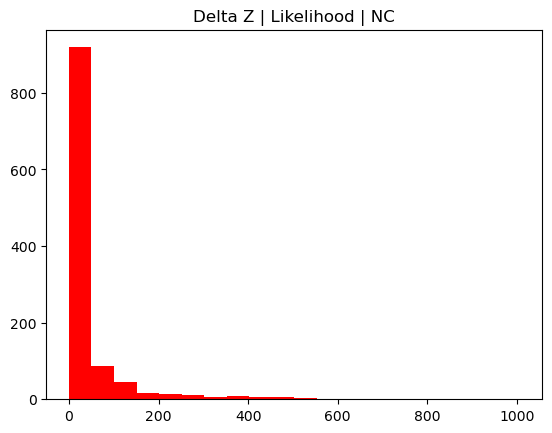

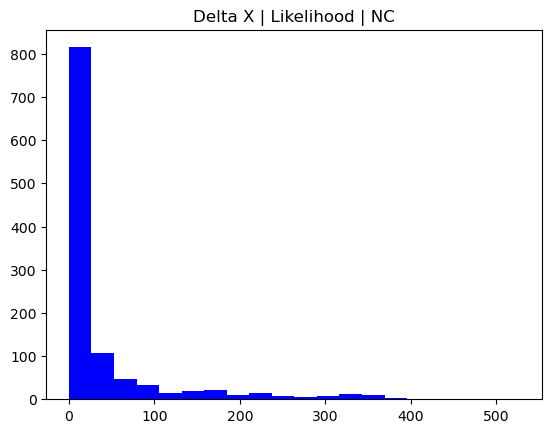

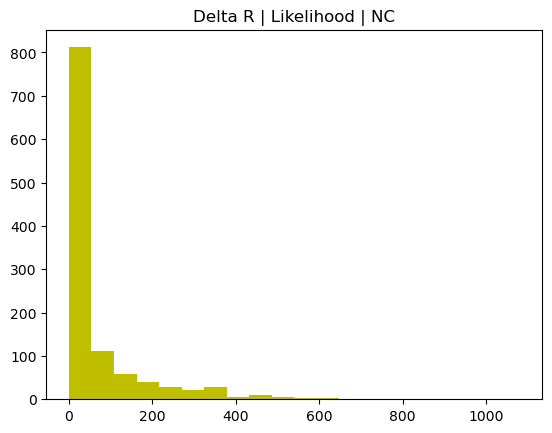

22.9497802734375 0.18904593639575973
22.199736022949224 0.19081272084805653
45.22958692640871 0.3003533568904594


  0%|                                                                                 | 1/1504 [00:01<31:14,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  0%|▏                                                                                | 4/1504 [00:05<31:56,  1.28s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  1%|▍                                                      

  2%|█▊                                                                              | 33/1504 [00:42<31:52,  1.30s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  2%|█▊                                                                              | 34/1504 [00:44<30:49,  1.26s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_

  4%|███                                                                             | 58/1504 [01:13<30:50,  1.28s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  4%|███▏                                                                            | 59/1504 [01:14<29:39,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  4%|███▏                                                   

  6%|████▋                                                                           | 89/1504 [01:54<29:30,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  6%|████▊                                                                           | 91/1504 [01:57<29:16,  1.24s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  6%|████▉                                                  

  8%|██████▎                                                                        | 119/1504 [02:31<27:43,  1.20s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
  8%|██████▍                                                                        | 123/1504 [02:35<24:31,  1.07s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 12%|█████████▉                                                                     | 188/1504 [03:55<25:51,  1.18s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 13%|█████████▉                                                                     | 189/1504 [03:56<27:19,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 15%|███████████▌                                                                   | 219/1504 [04:31<22:38,  1.06s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 15%|███████████▌                                                                   | 221/1504 [04:32<21:01,  1.02it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_

 18%|██████████████▍                                                                | 274/1504 [05:35<23:11,  1.13s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 18%|██████████████▍                                                                | 275/1504 [05:36<22:09,  1.08s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 18%|██████████████▌                                        

 20%|███████████████▍                                                               | 294/1504 [05:57<22:05,  1.10s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 20%|███████████████▋                                                               | 298/1504 [06:02<23:10,  1.15s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 20%|███████████████▋                                       

 23%|██████████████████▍                                                            | 352/1504 [07:12<23:42,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 23%|██████████████████▌                                                            | 353/1504 [07:13<22:11,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 24%|██████████████████▌                                    

 25%|███████████████████▉                                                           | 380/1504 [07:46<22:34,  1.20s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 25%|████████████████████                                                           | 381/1504 [07:47<22:38,  1.21s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 25%|████████████████████                                   

 27%|█████████████████████▋                                                         | 413/1504 [08:27<21:28,  1.18s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 28%|█████████████████████▊                                                         | 415/1504 [08:29<20:14,  1.11s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 28%|█████████████████████▊                                 

 30%|███████████████████████▌                                                       | 448/1504 [09:08<22:05,  1.26s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 30%|███████████████████████▋                                                       | 450/1504 [09:10<20:04,  1.14s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 30%|███████████████████████▋                               

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 32%|█████████████████████████▏                                                     | 479/1504 [09:43<19:09,  1.12s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 32%|█████████████████████████▎                                                     | 481/1504 [09:46<20:43,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

 34%|██████████████████████████▉                                                    | 514/1504 [10:27<19:18,  1.17s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 34%|███████████████████████████                                                    | 516/1504 [10:29<21:49,  1.32s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 34%|███████████████████████████▏                           

 36%|████████████████████████████▋                                                  | 546/1504 [11:06<21:08,  1.32s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 36%|████████████████████████████▋                                                  | 547/1504 [11:07<20:16,  1.27s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 36%|████████████████████████████▊                          

 39%|██████████████████████████████▋                                                | 585/1504 [11:53<17:11,  1.12s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 39%|██████████████████████████████▊                                                | 586/1504 [11:54<16:18,  1.07s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8:

 42%|█████████████████████████████████▎                                             | 634/1504 [12:52<18:05,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 42%|█████████████████████████████████▎                                             | 635/1504 [12:54<18:37,  1.29s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 42%|█████████████████████████████████▍                     

 44%|██████████████████████████████████▊                                            | 663/1504 [13:30<19:26,  1.39s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 44%|██████████████████████████████████▉                                            | 664/1504 [13:32<18:40,  1.33s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_

 45%|███████████████████████████████████▉                                           | 684/1504 [13:55<16:49,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 46%|████████████████████████████████████                                           | 687/1504 [13:59<17:03,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 46%|████████████████████████████████████▏                  

 48%|█████████████████████████████████████▋                                         | 718/1504 [14:35<14:42,  1.12s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 48%|█████████████████████████████████████▊                                         | 720/1504 [14:37<15:28,  1.18s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 48%|█████████████████████████████████████▉                 

 50%|███████████████████████████████████████▎                                       | 748/1504 [15:09<16:31,  1.31s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 50%|███████████████████████████████████████▍                                       | 750/1504 [15:11<15:17,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 50%|███████████████████████████████████████▌               

 52%|█████████████████████████████████████████                                      | 781/1504 [15:47<13:05,  1.09s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 52%|█████████████████████████████████████████                                      | 782/1504 [15:48<13:56,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 52%|█████████████████████████████████████████▏             

 54%|██████████████████████████████████████████▍                                    | 808/1504 [16:16<12:42,  1.09s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 54%|██████████████████████████████████████████▌                                    | 811/1504 [16:20<12:21,  1.07s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 54%|██████████████████████████████████████████▋            

 55%|███████████████████████████████████████████▊                                   | 834/1504 [16:46<11:43,  1.05s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 56%|███████████████████████████████████████████▊                                   | 835/1504 [16:47<12:02,  1.08s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 56%|███████████████████████████████████████████▉           

 57%|█████████████████████████████████████████████▍                                 | 864/1504 [17:21<14:11,  1.33s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 58%|█████████████████████████████████████████████▍                                 | 865/1504 [17:23<14:38,  1.37s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 58%|█████████████████████████████████████████████▍         

 61%|███████████████████████████████████████████████▊                               | 911/1504 [18:20<10:56,  1.11s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 61%|███████████████████████████████████████████████▉                               | 912/1504 [18:21<12:08,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 61%|███████████████████████████████████████

 62%|█████████████████████████████████████████████████                              | 935/1504 [18:51<11:49,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 62%|█████████████████████████████████████████████████▏                             | 936/1504 [18:52<12:22,  1.31s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 62%|█████████████████████████████████████████████████▏     

 64%|██████████████████████████████████████████████████▉                            | 970/1504 [19:34<10:14,  1.15s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 65%|███████████████████████████████████████████████████                            | 971/1504 [19:36<10:28,  1.18s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 65%|███████████████████████████████████████████████████    

 67%|████████████████████████████████████████████████████                          | 1005/1504 [20:16<09:34,  1.15s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 67%|████████████████████████████████████████████████████▏                         | 1006/1504 [20:17<10:42,  1.29s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_

 69%|█████████████████████████████████████████████████████▌                        | 1032/1504 [20:48<09:52,  1.26s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 69%|█████████████████████████████████████████████████████▌                        | 1033/1504 [20:49<09:13,  1.18s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

 73%|████████████████████████████████████████████████████████▋                     | 1092/1504 [22:10<07:56,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 73%|████████████████████████████████████████████████████████▊                     | 1095/1504 [22:13<08:23,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 73%|███████████████████████████████████████████████████████

 75%|██████████████████████████████████████████████████████████▋                   | 1132/1504 [22:57<07:21,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 75%|██████████████████████████████████████████████████████████▊                   | 1134/1504 [23:00<07:35,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 75%|███████████████████████████████████████████████████████

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 80%|██████████████████████████████████████████████████████████████                | 1197/1504 [24:10<05:09,  1.01s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 80%|██████████████████████████████████████████████████████████████▏               | 1198/1504 [24:11<06:00,  1.18s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736

 81%|███████████████████████████████████████████████████████████████▍              | 1223/1504 [24:41<05:32,  1.18s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 81%|███████████████████████████████████████████████████████████████▌              | 1225/1504 [24:43<05:55,  1.27s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 82%|███████████████████████████████████████████████████████

 83%|████████████████████████████████████████████████████████████████▊             | 1250/1504 [25:12<04:53,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 83%|████████████████████████████████████████████████████████████████▉             | 1251/1504 [25:14<05:01,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 83%|███████████████████████████████████████████████████████

 87%|███████████████████████████████████████████████████████████████████▋          | 1306/1504 [26:19<03:57,  1.20s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 87%|███████████████████████████████████████████████████████████████████▊          | 1308/1504 [26:21<03:50,  1.18s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 87%|███████████████████████████████████████████████████████

 89%|█████████████████████████████████████████████████████████████████████▍        | 1338/1504 [26:55<02:57,  1.07s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 89%|█████████████████████████████████████████████████████████████████████▌        | 1341/1504 [26:59<03:07,  1.15s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 89%|███████████████████████

 91%|██████████████████████████████████████████████████████████████████████▊       | 1366/1504 [27:28<02:48,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 91%|███████████████████████████████████████████████████████████████████████       | 1371/1504 [27:35<03:15,  1.47s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 91%|███████████████████████████████████████

 93%|████████████████████████████████████████████████████████████████████████▌     | 1398/1504 [28:08<02:03,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 93%|████████████████████████████████████████████████████████████████████████▌     | 1400/1504 [28:10<02:05,  1.21s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 93%|███████████████████████████████████████████████████████

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1459/1504 [29:20<00:52,  1.17s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 98%|████████████████████████████████████████████████████████████████████████████  | 1467/1504 [29:29<00:44,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 98%|███████████████████████████████████████████████████████

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1492/1504 [29:58<00:13,  1.14s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 99%|█████████████████████████████████████████████████████████████████████████████▍| 1493/1504 [29:59<00:13,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_

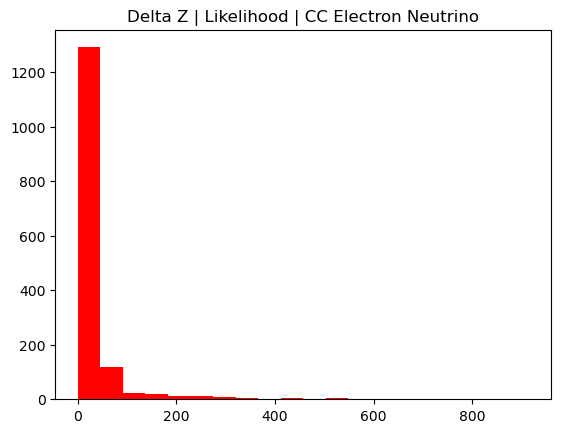

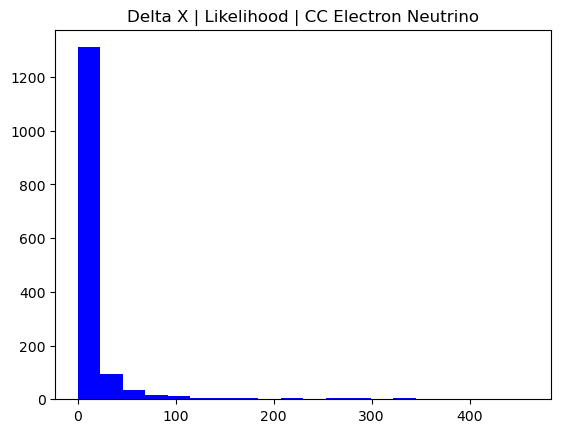

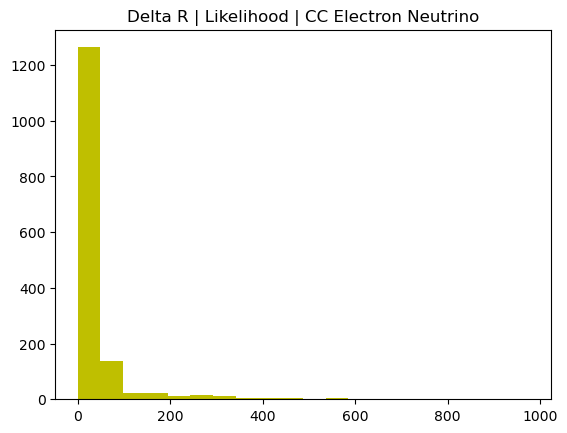

23.707650146484376 0.1283244680851064
7.162322635650639 0.061170212765957445
27.11169585671257 0.15492021276595744


  0%|                                                                                 | 3/2074 [00:03<37:40,  1.09s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  0%|▏                                                                                | 6/2074 [00:06<37:12,  1.08s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  0%|▎                                                      

  2%|█▉                                                                              | 51/2074 [01:07<45:10,  1.34s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
  3%|██▎                                                                             | 59/2074 [01:20<52:08,  1.55s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
  3%|██▎                                                                             | 60/2074 [01:22<59:33,  1.77s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in f

  6%|█████                                                                          | 132/2074 [03:01<43:34,  1.35s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  7%|█████▎                                                                         | 139/2074 [03:09<32:04,  1.01it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  7%|█████▌                                                 

 11%|████████▊                                                                      | 230/2074 [05:14<36:47,  1.20s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 11%|████████▊                                                                      | 232/2074 [05:17<37:49,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 11%|████████▉                                              

 19%|██████████████▋                                                                | 384/2074 [08:44<35:41,  1.27s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 19%|██████████████▉                                                                | 391/2074 [08:51<30:12,  1.08s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 19%|███████████████▏                       

 22%|█████████████████▎                                                             | 456/2074 [10:21<47:39,  1.77s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 22%|█████████████████▋                                                             | 465/2074 [10:33<42:29,  1.58s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 23%|██████████████████▏                                    

 28%|██████████████████████▎                                                        | 587/2074 [13:25<30:25,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 28%|██████████████████████▍                                                        | 590/2074 [13:29<37:47,  1.53s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 29%|███████████████████████                                

 34%|███████████████████████████                                                    | 711/2074 [16:26<37:58,  1.67s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 35%|███████████████████████████▎                                                   | 717/2074 [16:35<33:22,  1.48s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 35%|███████████████████████

 38%|██████████████████████████████▎                                                | 795/2074 [18:23<27:12,  1.28s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 38%|██████████████████████████████▎                                                | 797/2074 [18:26<28:19,  1.33s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 39%|██████████████████████████████▍        

 42%|█████████████████████████████████▎                                             | 876/2074 [20:14<28:13,  1.41s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 43%|█████████████████████████████████▌                                             | 882/2074 [20:22<24:53,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 43%|█████████████████████████████████▋                                             | 883/2074 [20:24<29:42,  1.50s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  s

 49%|█████████████████████████████████████▉                                        | 1008/2074 [23:22<25:17,  1.42s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 49%|██████████████████████████████████████                                        | 1012/2074 [23:27<24:10,  1.37s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 49%|██████████████████████████████████████▏                                       | 1014/2074 [23:31<26:06,  1.48s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by 

 51%|████████████████████████████████████████▏                                     | 1068/2074 [24:36<19:18,  1.15s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 52%|████████████████████████████████████████▍                                     | 1075/2074 [24:46<22:41,  1.36s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 52%|████████████████████████████████████████▋              

 56%|███████████████████████████████████████████▋                                  | 1160/2074 [26:46<24:20,  1.60s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 56%|███████████████████████████████████████████▋                                  | 1162/2074 [26:48<18:29,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 56%|███████████████████████████████████████████▊           

 63%|████████████████████████████████████████████████▊                             | 1298/2074 [29:55<18:58,  1.47s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 63%|████████████████████████████████████████████████▉                             | 1302/2074 [30:00<20:28,  1.59s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 63%|█████████████████████████████████████████████████      

 68%|████████████████████████████████████████████████████▋                         | 1401/2074 [32:21<18:27,  1.65s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 68%|████████████████████████████████████████████████████▊                         | 1403/2074 [32:25<17:47,  1.59s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 68%|███████████████████████████████████████

 72%|███████████████████████████████████████████████████████▉                      | 1488/2074 [34:27<15:01,  1.54s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 72%|████████████████████████████████████████████████████████▌                     | 1503/2074 [34:51<16:56,  1.78s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 73%|████████████████████████████████████████████████████████▌                     | 1505/2074 [34:54<16:02,  1.69s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  s

 77%|███████████████████████████████████████████████████████████▋                  | 1588/2074 [36:49<09:44,  1.20s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 77%|███████████████████████████████████████████████████████████▊                  | 1589/2074 [36:51<10:05,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 77%|███████████████████████████████████████████████████████████▉                  | 1593/2074 [36:57<12:06,  1.51s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in 

 80%|██████████████████████████████████████████████████████████████▌               | 1662/2074 [38:33<10:41,  1.56s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 80%|██████████████████████████████████████████████████████████████▋               | 1667/2074 [38:39<07:33,  1.12s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 80%|███████████████████████████████████████████████████████

 89%|█████████████████████████████████████████████████████████████████████▌        | 1849/2074 [42:44<05:00,  1.33s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 89%|█████████████████████████████████████████████████████████████████████▋        | 1852/2074 [42:48<05:35,  1.51s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 90%|███████████████████████████████████████

 92%|████████████████████████████████████████████████████████████████████████      | 1917/2074 [44:17<02:50,  1.09s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 93%|████████████████████████████████████████████████████████████████████████▏     | 1919/2074 [44:20<03:46,  1.46s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 93%|███████████████████████████████████████

 95%|██████████████████████████████████████████████████████████████████████████    | 1968/2074 [45:25<02:28,  1.40s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 95%|██████████████████████████████████████████████████████████████████████████    | 1970/2074 [45:29<03:18,  1.91s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 95%|███████████████████████████████████████

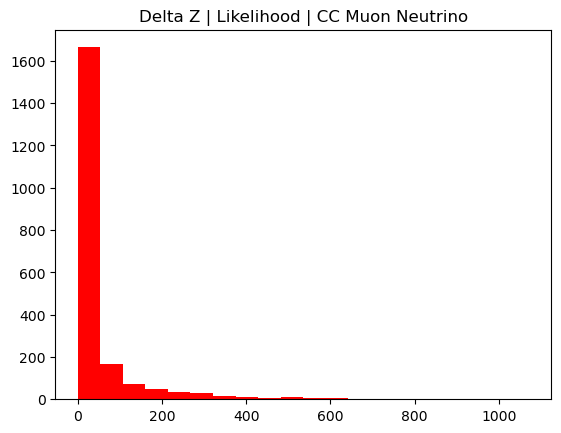

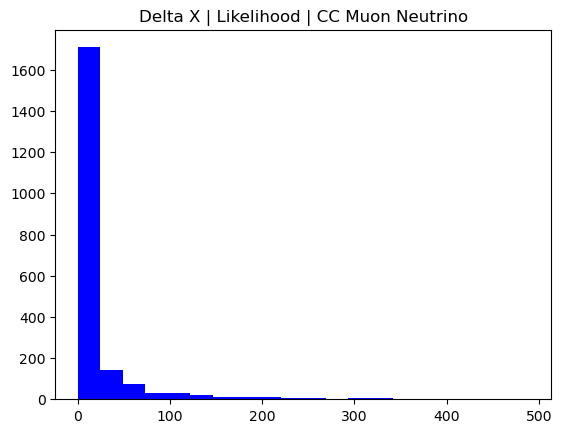

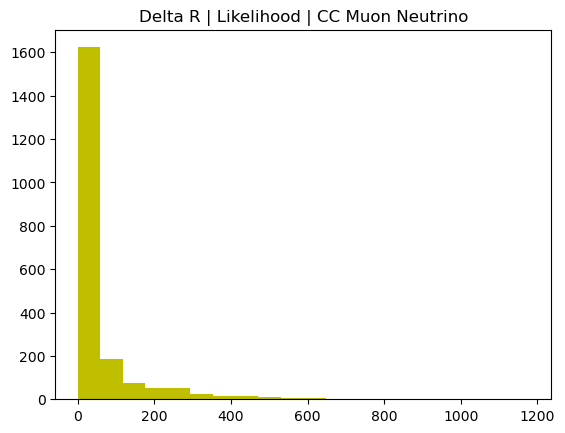

22.504318847656254 0.20588235294117646
7.80724069595337 0.10607521697203472
28.852613469044638 0.24059787849566056


In [117]:
z_hist_dataNC, x_hist_dataNC, r_hist_dataNC = create_likelihoods_metrics(NC_splitting)

plt.clf()
x = plt.hist(z_hist_dataNC, 20, color='r')
title = plt.title("Delta Z | Likelihood | NC")
plt.show()

plt.clf()
x = plt.hist(x_hist_dataNC, 20, color='b')
title = plt.title("Delta X | Likelihood | NC")
plt.show()

plt.clf()
x = plt.hist(r_hist_dataNC, 20, color='y')
title = plt.title("Delta R | Likelihood | NC")
plt.show()

r68Z, pecentage_fifty_cmZ = create_r68_and_50cm(z_hist_dataNC)
r68X, pecentage_fifty_cmX = create_r68_and_50cm(x_hist_dataNC)
r68R, pecentage_fifty_cmR = create_r68_and_50cm(r_hist_dataNC)

print(r68Z, pecentage_fifty_cmZ)
print(r68X, pecentage_fifty_cmX)
print(r68R, pecentage_fifty_cmR)




z_hist_dataCCE, x_hist_dataCCE, r_hist_dataCCE = create_likelihoods_metrics(EL_splitting)

plt.clf()
x = plt.hist(z_hist_dataCCE, 20, color='r')
title = plt.title("Delta Z | Likelihood | CC Electron Neutrino")
plt.show()

plt.clf()
x = plt.hist(x_hist_dataCCE, 20, color='b')
title = plt.title("Delta X | Likelihood | CC Electron Neutrino")
plt.show()

plt.clf()
x = plt.hist(r_hist_dataCCE, 20, color='y')
title = plt.title("Delta R | Likelihood | CC Electron Neutrino")
plt.show()

r68Z, pecentage_fifty_cmZ = create_r68_and_50cm(z_hist_dataCCE)
r68X, pecentage_fifty_cmX = create_r68_and_50cm(x_hist_dataCCE)
r68R, pecentage_fifty_cmR = create_r68_and_50cm(r_hist_dataCCE)

print(r68Z, pecentage_fifty_cmZ)
print(r68X, pecentage_fifty_cmX)
print(r68R, pecentage_fifty_cmR)





z_hist_dataCCMU, x_hist_dataCCMU, r_hist_dataCCMU = create_likelihoods_metrics(MU_splitting)

plt.clf()
x = plt.hist(z_hist_dataCCMU, 20, color='r')
title = plt.title("Delta Z | Likelihood | CC Muon Neutrino")
plt.show()

plt.clf()
x = plt.hist(x_hist_dataCCMU, 20, color='b')
title = plt.title("Delta X | Likelihood | CC Muon Neutrino")
plt.show()

plt.clf()
x = plt.hist(r_hist_dataCCMU, 20, color='y')
title = plt.title("Delta R | Likelihood | CC Muon Neutrino")
plt.show()

r68Z, pecentage_fifty_cmZ = create_r68_and_50cm(z_hist_dataCCMU)
r68X, pecentage_fifty_cmX = create_r68_and_50cm(x_hist_dataCCMU)
r68R, pecentage_fifty_cmR = create_r68_and_50cm(r_hist_dataCCMU)

print(r68Z, pecentage_fifty_cmZ)
print(r68X, pecentage_fifty_cmX)
print(r68R, pecentage_fifty_cmR)

In [121]:
def find_error_likelihood(sample, splits):
    samples = np.array_split(sample, splits)
    z_hist_means = []
    x_hist_means = []
    r_hist_means = []
    for i in range(len(samples)):
        z_hist_data, x_hist_data, r_hist_data = create_likelihoods_metrics(list(samples[i]))
        r68Z, pecentage_fifty_cmZ = create_r68_and_50cm(z_hist_data)
        r68X, pecentage_fifty_cmX = create_r68_and_50cm(x_hist_data)
        r68R, pecentage_fifty_cmR = create_r68_and_50cm(r_hist_data)
        
        z_hist_means.append(r68Z)
        x_hist_means.append(r68X)
        r_hist_means.append(r68R)
    
    z_hist_error = np.std(z_hist_means) / np.sqrt(len(z_hist_means))
    x_hist_error = np.std(x_hist_means) / np.sqrt(len(x_hist_means))
    r_hist_error = np.std(r_hist_means) / np.sqrt(len(r_hist_means))
    
    return z_hist_means, z_hist_error, x_hist_means, x_hist_error, r_hist_means, r_hist_error

In [122]:
z_hist_means, z_hist_error, x_hist_means, x_hist_error, r_hist_means, r_hist_error = find_error_likelihood(sample, 5)

print(z_hist_means, "\nError Z:", z_hist_error, x_hist_means, "\nError X:", x_hist_error, r_hist_means, "\nError R:", r_hist_error)

  0%|▍                                                                                 | 3/600 [00:04<16:36,  1.67s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  1%|▋                                                                                 | 5/600 [00:07<14:41,  1.48s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  1%|█                                                      

  9%|███████                                                                          | 52/600 [01:30<13:07,  1.44s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  9%|███████▎                                                                         | 54/600 [01:32<12:58,  1.43s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  9%|███████▌                                               

 23%|██████████████████▍                                                             | 138/600 [03:31<09:28,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 23%|██████████████████▌                                                             | 139/600 [03:33<10:40,  1.39s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 23%|██████████████████▋                                    

 28%|██████████████████████▌                                                         | 169/600 [04:13<09:25,  1.31s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 28%|██████████████████████▋                                                         | 170/600 [04:15<09:26,  1.32s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 29%|██████████████████████▉                

 39%|███████████████████████████████▍                                                | 236/600 [06:00<06:44,  1.11s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 40%|███████████████████████████████▋                                                | 238/600 [06:02<06:42,  1.11s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 40%|███████████████████████████████▊                       

 46%|████████████████████████████████████▋                                           | 275/600 [06:56<09:31,  1.76s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 46%|█████████████████████████████████████                                           | 278/600 [06:59<07:25,  1.38s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 46%|█████████████████████████████████████▏                                          | 279/600 [07:01<07:39,  1.43s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in f

 54%|██████████████████████████████████████████▉                                     | 322/600 [08:06<06:53,  1.49s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 54%|███████████████████████████████████████████                                     | 323/600 [08:07<06:28,  1.40s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 54%|███████████████████████████████████████████▍           

 62%|█████████████████████████████████████████████████▌                              | 372/600 [09:25<04:32,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 62%|█████████████████████████████████████████████████▊                              | 374/600 [09:27<04:23,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 63%|██████████████████████████████████████████████████▏    

 68%|██████████████████████████████████████████████████████▎                         | 407/600 [10:11<04:20,  1.35s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 68%|██████████████████████████████████████████████████████▊                         | 411/600 [10:16<03:42,  1.18s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 69%|██████████████████████████████████████████████████████▉

 75%|███████████████████████████████████████████████████████████▋                    | 448/600 [11:08<02:47,  1.10s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 75%|████████████████████████████████████████████████████████████                    | 450/600 [11:10<02:33,  1.02s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 75%|███████████████████████████████████████

 84%|██████████████████████████████████████████████████████████████████▉             | 502/600 [12:18<03:24,  2.09s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 84%|███████████████████████████████████████████████████████████████████             | 503/600 [12:20<02:52,  1.78s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 84%|███████████████████████████████████████████████████████

 91%|████████████████████████████████████████████████████████████████████████▉       | 547/600 [13:21<01:13,  1.39s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 91%|█████████████████████████████████████████████████████████████████████████       | 548/600 [13:22<01:09,  1.34s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 92%|███████████████████████████████████████████████████████

 99%|███████████████████████████████████████████████████████████████████████████████▏| 594/600 [14:23<00:07,  1.32s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 99%|███████████████████████████████████████████████████████████████████████████████▎| 595/600 [14:25<00:06,  1.30s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
100%|███████████████████████████████████████████████████████

  8%|██████▏                                                                          | 46/600 [01:02<11:45,  1.27s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  8%|██████▍                                                                          | 48/600 [01:04<09:39,  1.05s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
  8%|██████▌                                

 21%|█████████████████                                                               | 128/600 [03:24<12:12,  1.55s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 22%|█████████████████▏                                                              | 129/600 [03:25<11:44,  1.50s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 22%|█████████████████▍                                     

 26%|████████████████████▉                                                           | 157/600 [04:05<11:11,  1.52s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 26%|█████████████████████▏                                                          | 159/600 [04:07<09:11,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 27%|█████████████████████▎                 

 32%|█████████████████████████▎                                                      | 190/600 [04:50<10:15,  1.50s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 32%|█████████████████████████▍                                                      | 191/600 [04:51<09:55,  1.46s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 32%|█████████████████████████▌             

 38%|██████████████████████████████▎                                                 | 227/600 [05:39<07:03,  1.13s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 38%|██████████████████████████████▍                                                 | 228/600 [05:40<07:22,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 38%|██████████████████████████████▌                        

 45%|████████████████████████████████████▏                                           | 271/600 [06:45<07:26,  1.36s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 45%|████████████████████████████████████▎                                           | 272/600 [06:46<06:54,  1.26s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25

 51%|████████████████████████████████████████▋                                       | 305/600 [07:34<06:01,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 51%|████████████████████████████████████████▊                                       | 306/600 [07:35<06:51,  1.40s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 52%|███████████████████████████████████████

 60%|███████████████████████████████████████████████▋                                | 358/600 [08:54<06:08,  1.52s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 60%|████████████████████████████████████████████████▏                               | 361/600 [08:58<04:44,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 61%|████████████████████████████████████████████████▋      

 66%|████████████████████████████████████████████████████▌                           | 394/600 [09:44<04:34,  1.33s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 66%|████████████████████████████████████████████████████▊                           | 396/600 [09:47<05:12,  1.53s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 66%|████████████████████████████████████████████████████▉  

 82%|█████████████████████████████████████████████████████████████████▏              | 489/600 [12:07<02:35,  1.40s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 83%|██████████████████████████████████████████████████████████████████▍             | 498/600 [12:21<02:16,  1.34s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 83%|███████████████████████████████████████

 91%|█████████████████████████████████████████████████████████████████████████       | 548/600 [13:40<01:16,  1.46s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 92%|█████████████████████████████████████████████████████████████████████████▍      | 551/600 [13:45<01:20,  1.64s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 92%|███████████████████████████████████████████████████████

100%|███████████████████████████████████████████████████████████████████████████████▊| 599/600 [15:09<00:01,  1.37s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  0%|                                                                                          | 0/600 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_

  6%|████▊                                                                            | 36/600 [00:47<13:45,  1.46s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  6%|████▉                                                                            | 37/600 [00:48<12:38,  1.35s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  6%|█████▏                                                 

 15%|████████████                                                                     | 89/600 [02:04<16:53,  1.98s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 15%|████████████▏                                                                    | 90/600 [02:05<14:38,  1.72s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 17%|█████████████▎                                         

 30%|███████████████████████▊                                                        | 179/600 [04:11<08:25,  1.20s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 30%|████████████████████████▎                                                       | 182/600 [04:15<08:16,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 31%|████████████████████████▌                                                       | 

 35%|███████████████████████████▊                                                    | 209/600 [04:50<08:09,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 36%|████████████████████████████▍                                                   | 213/600 [04:55<08:30,  1.32s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 36%|████████████████████████████▊          

 41%|████████████████████████████████▋                                               | 245/600 [05:41<08:26,  1.43s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 42%|█████████████████████████████████▏                                              | 249/600 [05:46<06:39,  1.14s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 42%|█████████████████████████████████▍                     

 48%|██████████████████████████████████████▎                                         | 287/600 [06:49<08:07,  1.56s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 48%|██████████████████████████████████████▍                                         | 288/600 [06:50<07:48,  1.50s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736

 53%|██████████████████████████████████████████▍                                     | 318/600 [07:29<06:11,  1.32s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 54%|██████████████████████████████████████████▊                                     | 321/600 [07:33<07:08,  1.54s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 54%|███████████████████████████████████████████                                     | 323/600 [07:36<07:47,  1.69s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x

 59%|███████████████████████████████████████████████▍                                | 356/600 [08:16<04:25,  1.09s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 60%|███████████████████████████████████████████████▌                                | 357/600 [08:17<04:14,  1.05s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 60%|███████████████████████████████████████████████▋       

 68%|██████████████████████████████████████████████████████                          | 405/600 [09:29<05:42,  1.76s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 68%|██████████████████████████████████████████████████████▎                         | 407/600 [09:31<04:15,  1.32s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 68%|██████████████████████████████████████████████████████▌

 74%|███████████████████████████████████████████████████████████▏                    | 444/600 [10:19<03:11,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 74%|███████████████████████████████████████████████████████████▎                    | 445/600 [10:20<02:58,  1.15s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 74%|███████████████████████████████████████████████████████████▌                    | 447/600 [10:24<03:35,  1.41s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  s

 87%|█████████████████████████████████████████████████████████████████████▌          | 522/600 [12:18<02:04,  1.60s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 87%|█████████████████████████████████████████████████████████████████████▊          | 524/600 [12:20<01:38,  1.30s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736

 94%|███████████████████████████████████████████████████████████████████████████     | 563/600 [13:12<00:50,  1.35s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 94%|███████████████████████████████████████████████████████████████████████████▏    | 564/600 [13:13<00:47,  1.33s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 94%|███████████████████████████████████████

 99%|███████████████████████████████████████████████████████████████████████████████▎| 595/600 [13:51<00:07,  1.49s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 99%|███████████████████████████████████████████████████████████████████████████████▍| 596/600 [13:52<00:05,  1.29s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_

  5%|████▏                                                                          | 32/600 [00:59<1:02:01,  6.55s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  6%|█████▏                                                                           | 38/600 [01:08<18:14,  1.95s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
  7%|█████▌                                                 

 12%|█████████▋                                                                       | 72/600 [01:55<20:36,  2.34s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 12%|█████████▊                                                                       | 73/600 [01:56<16:50,  1.92s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 12%|█████████▉                                             

 18%|██████████████▍                                                                 | 108/600 [02:42<09:04,  1.11s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 19%|██████████████▉                                                                 | 112/600 [02:47<09:54,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 19%|███████████████▏                                       

 26%|█████████████████████                                                           | 158/600 [03:58<12:28,  1.69s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 26%|█████████████████████▏                                                          | 159/600 [03:59<11:54,  1.62s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 27%|█████████████████████▍                                 

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 34%|██████████████████████████▉                                                     | 202/600 [05:04<09:12,  1.39s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 34%|███████████████████████████▌                                                    | 207/600 [05:12<12:03,  1.84s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_

 42%|█████████████████████████████████▍                                              | 251/600 [06:15<07:26,  1.28s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 42%|█████████████████████████████████▋                                              | 253/600 [06:17<06:42,  1.16s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 43%|██████████████████████████████████▋                    

 57%|█████████████████████████████████████████████▌                                  | 342/600 [08:42<12:42,  2.95s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)
 57%|█████████████████████████████████████████████▋                                  | 343/600 [08:43<10:14,  2.39s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 58%|██████████████████████████████████████████████▏              

 70%|███████████████████████████████████████████████████████▋                        | 418/600 [10:28<03:16,  1.08s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 70%|███████████████████████████████████████████████████████▊                        | 419/600 [10:29<03:20,  1.11s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 70%|███████████████████████████████████████████████████████

 76%|████████████████████████████████████████████████████████████▌                   | 454/600 [11:21<02:58,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 76%|████████████████████████████████████████████████████████████▊                   | 456/600 [11:26<04:05,  1.70s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 76%|███████████████████████████████████████████████████████

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 85%|████████████████████████████████████████████████████████████████████            | 510/600 [12:47<01:56,  1.30s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 85%|████████████████████████████████████████████████████████████████████▏           | 511/600 [12:48<01:51,  1.25s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736

 98%|██████████████████████████████████████████████████████████████████████████████  | 585/600 [14:23<00:16,  1.13s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 98%|██████████████████████████████████████████████████████████████████████████████▏ | 586/600 [14:24<00:15,  1.13s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 98%|██████████████████████████████████████████████████████████████████████████████▍ | 588/600 [14:28<00:17,  1.42s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered

 13%|██████████▋                                                                      | 79/600 [01:49<09:19,  1.07s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 14%|██████████▉                                                                      | 81/600 [01:51<10:30,  1.22s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 14%|███████████                                            

 21%|█████████████████                                                               | 128/600 [02:56<09:38,  1.23s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 22%|█████████████████▎                                                              | 130/600 [02:59<10:49,  1.38s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 22%|█████████████████▋                                     

 29%|███████████████████████▍                                                        | 176/600 [04:17<11:50,  1.68s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 30%|████████████████████████▎                                                       | 182/600 [04:24<09:14,  1.33s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 30%|████████████████████████▍                              

 48%|██████████████████████████████████████▏                                         | 286/600 [06:32<06:13,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 48%|██████████████████████████████████████▍                                         | 288/600 [06:34<05:45,  1.11s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 48%|██████████████████████████████████████▌                

 57%|█████████████████████████████████████████████▊                                  | 344/600 [07:37<04:24,  1.03s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 58%|██████████████████████████████████████████████▏                                 | 346/600 [07:40<05:26,  1.28s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 58%|██████████████████████████████████████████████▍        

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 62%|█████████████████████████████████████████████████▎                              | 370/600 [08:11<04:55,  1.28s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(p

 71%|████████████████████████████████████████████████████████▌                       | 424/600 [09:24<04:31,  1.54s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
 71%|████████████████████████████████████████████████████████▋                       | 425/600 [09:25<04:06,  1.41s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_

 79%|██████████████████████████████████████████████████████████████▉                 | 472/600 [10:33<04:15,  1.99s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 80%|████████████████████████████████████████████████████████████████                | 480/600 [10:44<02:50,  1.42s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 80%|███████████████████████████████████████████████████████

 86%|█████████████████████████████████████████████████████████████████████▏          | 519/600 [11:33<01:30,  1.12s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 87%|█████████████████████████████████████████████████████████████████████▎          | 520/600 [11:34<01:21,  1.02s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 87%|███████████████████████████████████████████████████████

 93%|██████████████████████████████████████████████████████████████████████████▎     | 557/600 [12:18<00:58,  1.36s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 93%|██████████████████████████████████████████████████████████████████████████▌     | 559/600 [12:20<00:48,  1.19s/it]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
 94%|███████████████████████████████████████████████████████

[27.70910156250001, 22.549587402343754, 25.12688781738283, 28.561938629150415, 22.079892578125] 
Error Z: 1.172402224676113 [10.739094238281254, 10.390438537597664, 11.284245300292993, 12.326741333007815, 9.853610839843752] 
Error X: 0.3774618923264345 [33.96639933640774, 35.82377109278393, 32.89644931685143, 36.477314340953704, 30.748286507205616] 
Error R: 0.9220472884195322


In [130]:
theta_u = 0.623257100582
theta_v = -0.623257100582
theta_w = 0.

cos_u = np.cos(theta_u)
cos_v = np.cos(theta_v)
cos_w = np.cos(theta_w)
sin_u = np.sin(theta_u)
sin_v = np.sin(theta_v)
sin_w = np.sin(theta_w)

sin_dvu = np.sin(theta_v - theta_u)
sin_dwv = np.sin(theta_w - theta_v)
sin_duw = np.sin(theta_u - theta_w)

def uv_to_y(u, v):
    return ((u * cos_v - v * cos_u) / sin_dvu)

def uv_to_z(u, v):
    return ((u * sin_v - v * sin_u) / sin_dvu)

def uw_to_y(u, w):
    return ((w * cos_u - u * cos_w) / sin_duw)

def uw_to_z(u, w):
    return ((w * sin_u - u * sin_w) / sin_duw)

def vw_to_y(v, w):
    return ((v * cos_w - w * cos_v) / sin_dwv)

def vw_to_z(v, w):
    return ((v * sin_w - w * sin_v) / sin_dwv)

# 3D to wire
def yz_to_u(y, z):
    return z * cos_u - y * sin_u

def yz_to_v(y, z):
    return z * cos_v - y * sin_v

def yz_to_w(y, z):
    return z * cos_w - y * sin_w

def uv_to_yz(u, v):
    return uv_to_y(u, v), uv_to_z(u, v)

def uw_to_yz(u, w):
    return uw_to_y(u, w), uw_to_z(u, w)

def vw_to_yz(v, w):
    return vw_to_y(v, w), vw_to_z(v, w)

sample = random.sample(range(0, len(u_x)), 3000)

def create_likelihood_metrics_3D(sample):
    x_hist_data = [None] * len(sample)
    y_hist_data = [None] * len(sample)
    z_hist_data = [None] * len(sample)
    r_hist_data = [None] * len(sample)
    for i in tqdm(range(len(sample))):
        sample_no = [sample[i]]
        AoI_xu, AoI_zu, AoI_adcu, Zvert_true_placeu, Xvert_true_placeu = AoI("u", sample[i])
        scores = create_likelihoods_metrics("u", sample_no)
        max_score = np.amax(scores)
        ind = np.where(max_score)[0]
        x_posu, z_posu = AoI_xu[ind], AoI_zu[ind]
        
        AoI_xv, AoI_zv, AoI_adcv, Zvert_true_placev, Xvert_true_placev = AoI("v", sample[i])
        scores = create_likelihoods_metrics("v", sample_no)
        max_score = np.amax(scores)
        ind = np.where(max_score)[0]
        x_posv, z_posv = AoI_xv[ind], AoI_zv[ind]
        
        AoI_xw, AoI_zw, AoI_adcw, Zvert_true_placew, Xvert_true_placew = AoI("w", sample[i])
        scores = create_likelihoods_metrics("w", sample_no)
        max_score = np.amax(scores)
        ind = np.where(max_score)[0]
        x_posw, z_posw = AoI_xw[ind], AoI_zw[ind]
        
        
        x_diff = np.abs(((x_posu + x_posv + x_posw) / 3) - ((Xvert_true_placeu + Xvert_true_placev + Xvert_true_placew) / 3))
        
        yuv, zuv = uv_to_yz(z_posu, z_posv)
        yuw, zuw = uw_to_yz(z_posu, z_posw)
        yvw, zvw = vw_to_yz(z_posv, z_posw)
        
        yuv_true, zuv_true = uv_to_yz(Zvert_true_placeu, Zvert_true_placev)
        yuw_true, zuw_true = uw_to_yz(Zvert_true_placeu, Zvert_true_placew)
        yvw_true, zvw_true = vw_to_yz(Zvert_true_placev, Zvert_true_placew)
        
        y_diff = np.abs(((yuv + yuw + yvw) / 3) - ((yuv_true + yuw_true + yvw_true) / 3))
        z_diff = np.abs(((zuv + zuw + zvw) / 3) - ((zuv_true + zuw_true + zvw_true) / 3))
        
        r_diff = (x_diff ** 2 + y_diff ** 2 + z_diff ** 2)**(1/2)
        
        x_hist_data[i], y_hist_data[i], z_hist_data[i], r_hist_data[i] = x_diff[0], y_diff[0], z_diff[0], r_diff[0]

    
    return z_hist_data, y_hist_data, x_hist_data, r_hist_data

In [132]:
z_hist_data, y_hist_data, x_hist_data, r_hist_data = create_likelihood_metrics_3D(sample)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 -

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

100%|████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|█████████████████████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|███████████████████████████████████

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                        


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]

100%|███████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]

100%|████████████████████████████████████████

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encount


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

  0%|                                       

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  2.00s/it]

100%|████████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

  0%|                                       

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.01s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

  0%|                                        

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.85s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]

  0%|                                       

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]

100%|███████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - poin

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]

100%|████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.03s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]

100%|███████████████████████████████████████


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.38s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

  0%|                                       


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]

100%|███████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]

  0%|                        

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - po

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.98s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.81s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - po


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]

100%|███████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - po


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]

  0%|                                        

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]

100%|████████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.78s/it]

100%|███████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.59s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.79s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 -

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]

  0%|                                                                                            | 0/1 [0

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]

100%|███████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]

  0%|                                        

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]

100%|████████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encoun


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encount

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]

  0%|                                       


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.08s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]

  0%|                                       


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.50s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.73s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

100%|███████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|███████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|█████████████████████████████████████████████████████

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 -


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)

100%

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 -

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|███████████████████████████████████

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]

  0%|                                       


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]

100%|███████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.81s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.06s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encou


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]

  0%|                                       

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid v

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encoun


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]

100%|███████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encoun


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invali

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.83s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                       

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encounte

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|███████████████████████████████████


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]

  0%|                                        


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

100%

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                        


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encounter


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|███████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

100%|████████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - i

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]

  0%|                                        

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]

  0%|                        

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|███████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.26s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.76s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid v


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.23s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]

  0%|                                                                                      

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]

  0%|                                        


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encoun


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]

100%|████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid va

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]

100%|███████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invali

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

  0%|                                        


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encou

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]

100%|████████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - poin


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]

100%|███████████████████████████████████████


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]

  0%|                                        

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

  0%|                                        


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]

  0%


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]

100%|███████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.68s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]

  0%|                        


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|█████████████████████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]

  0%|                                        

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]

100%|████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.96s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]

100%|████████████████████████████████████████

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|███████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - i


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

100%|███████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.67s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in fl

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.14it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]

100%|████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.06it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\T


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]

100%|███████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|███████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|███████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|██████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.16s/it]

  0%|                                        

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 -


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.19s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]

100%|███████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]

100%|████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|███████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]

  0%|                                       

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]

  0%|                                        

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: inval


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounte

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]

100%|████████████████████████████████████████

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

100%|████████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.15it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.01s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:121: RuntimeWarning: invalid value encountered in true_divide
  scores = weights/np.amax(weights)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.59s/it]

  0%|                                                                                            | 0/1 [00:0

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  slope = (point1[1] - point2[1])/(point1[0] - point2[0])
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: invalid value encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)

100%|████████████████████████████████████


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.17s/it]

  0%|                                       


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encounter

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(sl

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.75s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid va


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|███████████████████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_255


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  x_point = (intercept2 - intercept1)/(slope1 - slope2)
C:\Users\alexg\AppData\Local\Temp\ipykernel_25564\2132870736.py:8: RuntimeWarning: invalid value encountered in float_scalars
  z_point = slope1 * x_point + intercept1

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [3:48:44<00:00,  4.57s/it]


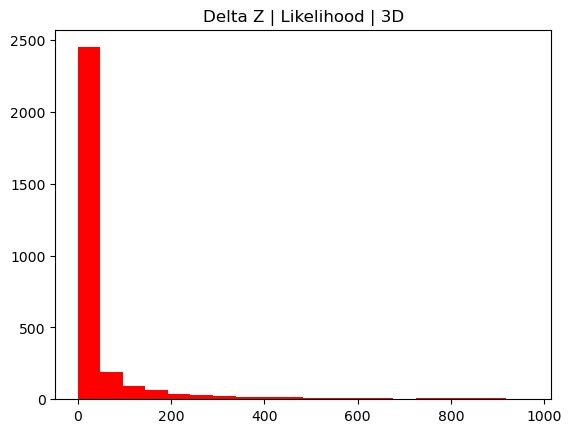

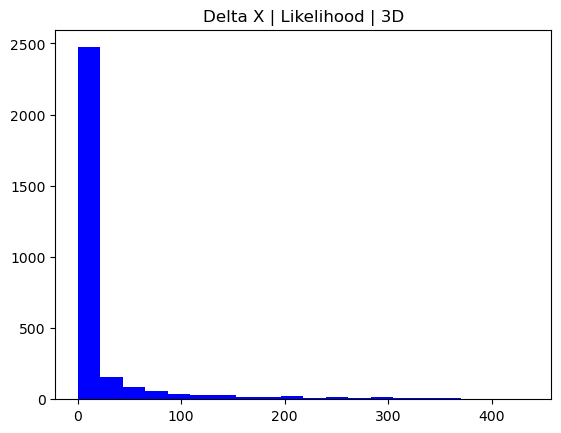

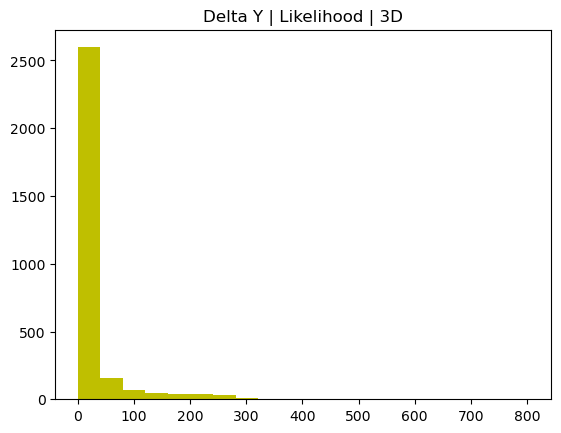

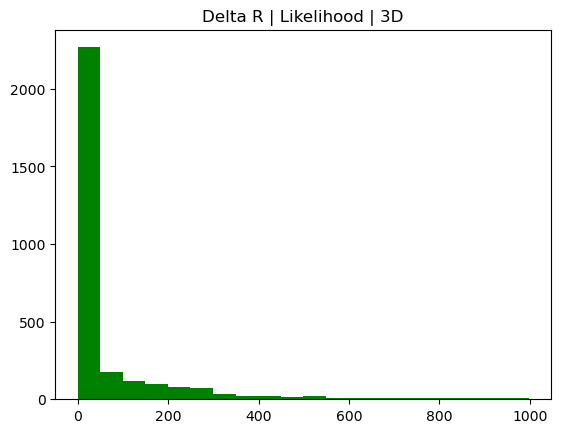

11.77203857421876 0.18
7.018491516113285 0.11633333333333333
3.544404296875001 0.111
20.019713134765635 0.24433333333333335


In [133]:
plt.clf()
x = plt.hist(z_hist_data, 20, color='r')
title = plt.title("Delta Z | Likelihood | 3D")
plt.show()

plt.clf()
x = plt.hist(x_hist_data, 20, color='b')
title = plt.title("Delta X | Likelihood | 3D")
plt.show()

plt.clf()
x = plt.hist(y_hist_data, 20, color='y')
title = plt.title("Delta Y | Likelihood | 3D")
plt.show()

plt.clf()
x = plt.hist(r_hist_data, 20, color='g')
title = plt.title("Delta R | Likelihood | 3D")
plt.show()

r68Z, pecentage_fifty_cmZ = create_r68_and_50cm(z_hist_data)
r68Y, pecentage_fifty_cmY = create_r68_and_50cm(y_hist_data)
r68X, pecentage_fifty_cmX = create_r68_and_50cm(x_hist_data)
r68R, pecentage_fifty_cmR = create_r68_and_50cm(r_hist_data)

print(r68Z, pecentage_fifty_cmZ)
print(r68Y, pecentage_fifty_cmY)
print(r68X, pecentage_fifty_cmX)
print(r68R, pecentage_fifty_cmR)